### Author: Rohan Thakkar
### Credits for data source: DataLab, University of Washington Seattle 

## Introduction to the problem


In this assignment, we'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

It's a meta-review website that aggregates movie reviews from a large number of critics. Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

Our mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import sklearn
from  sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

---

## Part 1: Descriptive analysis

Let us begin by loading the datasets and dropping rows that have missing data:

In [2]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')
reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]

### 1.1: Basic features of the dataset


* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [3]:
print "There are %i unique reviews (quotes) in the reviews dataset." % len(reviews.quote.unique())

print "There are %i unique reviews (critics) in the reviews dataset." % len(reviews.critic.unique())

print "There are %i unique movies in the reviews dataset." % len(reviews.title.unique())

print "There are %i unique movies in the movies dataset." % len(movies.title.unique())

print "There are %i different publications have reviews in the reviews dataset." % len(reviews.publication.unique())

There are 12814 unique reviews (quotes) in the reviews dataset.
There are 541 unique reviews (critics) in the reviews dataset.
There are 1720 unique movies in the reviews dataset.
There are 9405 unique movies in the movies dataset.
There are 64 different publications have reviews in the reviews dataset.


### 1.2 Number of reviews per reviewer


Using the `reviews` dataset, let us create a histogram showing the distribution of the number of reviews per reviewer

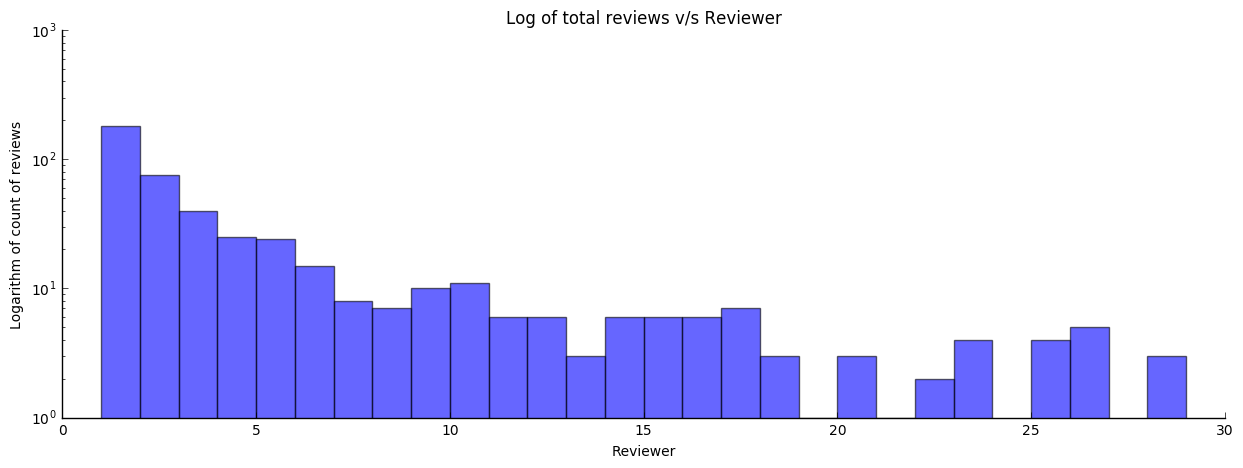

In [4]:
# Spreading the plot to wider extent
plt.figure(figsize=(15,5))

# Creating a subplot of matplotlib to incorporate required modifications
ax = plt.subplot(111)

# Hiding the right and top axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


# Grouping by critic
d = pd.groupby(reviews, by = reviews.critic)

# Counting the ones which are non-zero
d = d.agg(np.count_nonzero)

# Histogram with bin width=1 and range = (0,30)
plot = ax.hist(d.title, bins=np.arange(0, 30, 1), color = 'blue', alpha = 0.6)

# Calculating Y-axis as log of total number of reviews
plt.yscale('log', nonposy='clip')

# Labeling the graph
plt.xlabel("Reviewer")
plt.ylabel("Logarithm of count of reviews")
plt.title("Log of total reviews v/s Reviewer")

plt.show()

### 1.3 Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

In [5]:
## Sorting in descending order by number of reviews
e = d.sort(['title'],ascending = [False])

## Index is the name of critic
index = e.index[xrange(30)]

## To find first date
f = pd.groupby(reviews, by = reviews.critic).agg(np.min)

## To find last date
g = pd.groupby(reviews, by = reviews.critic).agg(np.max)

## To find number of reviews
h = pd.groupby(reviews, by = reviews.critic).count()

first= []
last = []
pub = []
total = []
for i in index:
    first.append(f.review_date[f.index == i])
    last.append(g.review_date[g.index == i])
    # max since 'Roger Ebert' worked for more than 1 publication in his career
    pub.append(reviews.publication[reviews.critic==i].max())
    total.append(h.title[h.index==i])

## Clubbing the columns
final = np.column_stack((index,pub,first, last,total))  

## To data frame
yolo = pd.DataFrame(final)  

# Renaming columns
yolo.columns=['critic','pub','first','last','count']

# Displaying resultant data frame
yolo

/Users/rohanmanojthakkar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,critic,pub,first,last,count
0,Roger Ebert,Chicago Sun-Times,2000-01-01 00:00:00,2013-06-11 00:00:00,1150
1,James Berardinelli,ReelViews,1800-01-01 00:00:00,2012-02-07 00:00:00,833
2,Janet Maslin,New York Times,2000-01-01 00:00:00,2010-09-07 00:00:00,526
3,Variety Staff,Variety,2001-02-13 00:00:00,2012-08-15 00:00:00,449
4,Jonathan Rosenbaum,Chicago Reader,1988-07-11 00:00:00,2013-10-22 00:00:00,420
5,Desson Thomson,Washington Post,2000-01-01 00:00:00,2012-10-08 00:00:00,373
6,Geoff Andrew,Time Out,2005-08-11 00:00:00,2012-04-05 00:00:00,361
7,Dave Kehr,New York Daily News,2000-01-01 00:00:00,2013-11-20 00:00:00,360
8,Kenneth Turan,Los Angeles Times,2000-01-01 00:00:00,2013-10-05 00:00:00,282
9,Mick LaSalle,San Francisco Chronicle,2000-01-01 00:00:00,2009-11-25 00:00:00,280


### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing our results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.

In [6]:
# Converting rtAllCriticsRating from object to numeric
ratings = movies.rtAllCriticsRating.convert_objects(convert_numeric=True)

# Deleting column with object data type
del movies['rtAllCriticsRating']


# Adding column with same values but in numeric form
movies['rtAllCriticsRating'] = ratings

/Users/rohanmanojthakkar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


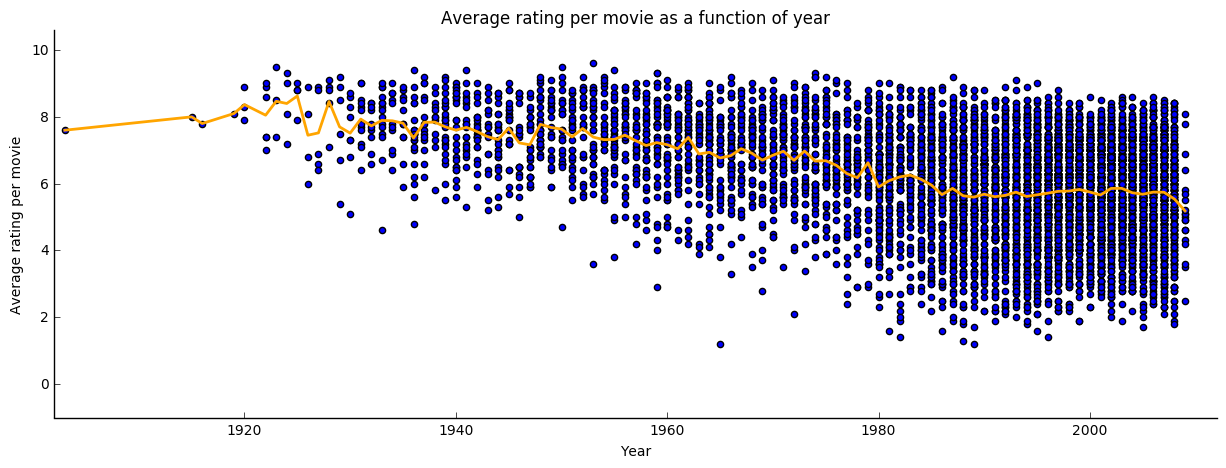

In [7]:
# Widening graph width
plt.figure(figsize=(15,5))

# Creating a subplot of matplotlib to incorporate required modifications
ax = plt.subplot(111)

# Hiding the right and top axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Filtering for positive ratings and plotting scatterplot
plt.scatter(movies.year[movies.rtAllCriticsRating>0], movies.rtAllCriticsRating[movies.rtAllCriticsRating>0])

# Adjusting scale of Y-axis
plt.ylim([movies.rtAllCriticsRating.min()-1,movies.rtAllCriticsRating.max()+1])
# Adjusting scale of X-axis
plt.xlim([movies.year.min()-1,movies.year.max()+1])

# Grouping by movies on filter of positive critics
tp = pd.DataFrame.groupby(movies[movies.rtAllCriticsRating>0], by = movies[movies.rtAllCriticsRating>0].year).mean()


# Plotting line graph to show average critic rating per year
plt.plot(tp.index, tp.rtAllCriticsRating, 'orange',  linewidth = 2)

plt.xlabel("Year")
plt.ylabel("Average rating per movie")
plt.title("Average rating per movie as a function of year")

plt.show()

By looking at the above graph, we understand that in general, the average rating per movie decreases with time because the line tends to go downward as the value in X-axis rises.

This means, that on an average, the critics started being more strict in their ratings on a movie and with the number of movies increasing with time, the percentage of good movies in a year starts to decrease with these additional movies that do not manage to impress the critics.

---

## Part 2: Naive Bayes

Let us use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print "Original text is\n", '\n'.join(text)

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print
print "Transformed text vector is \n", x

# `get_feature_names` tracks which word is associated with each column of the transformed x
print
print "Words for each feature:"
print vectorizer.get_feature_names()

Original text is
machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
[[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:
[u'learning', u'machine', u'rocks', u'rules']


### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

In [9]:
def make_xy(reviews, vectorizer=None):
    temp = reviews.quote
    # Create new only if vectorizer is none
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df=0)
    
    X = vectorizer.fit_transform(temp)
    Y = (reviews.fresh=='fresh').values.astype(np.int)
    return X, Y

In [10]:
X, Y = make_xy(reviews)

### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set and a validation set.

In [11]:
train_X, test_X,train_Y, test_Y = sklearn.cross_validation.train_test_split(X,Y)

### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 object.  Report the accuracy of this model on both the training and testing data.  Let us also interpret the observations.

In [12]:
fitted_model = sklearn.naive_bayes.MultinomialNB()

fitted_model.fit(train_X,train_Y)

print 'Performance of training set is =',(1-(abs(fitted_model.predict(train_X)-train_Y).sum())/float(len(train_Y)))*100,'%'

print 'Performance of test set is =',(1-(abs(fitted_model.predict(test_X)-test_Y).sum())/float(len(test_Y)))*100,'%'

Performance of training set is = 92.4085850556 %
Performance of test set is = 78.0625931446 %


Thus, we see that the accuracy of the Naive Bayes model implemented is great for the training data and average for the test data which means that training set achieves better performance as expected because the model is fit on that data and the test data has a decent performance too.

---

## Part 3: Evaluation

### 3.1 Estimate the likelihood of data

Given a fitted model, we can compute the log-likelihood of our data as a way to assess the performance of our model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of our training and testing data given our fitted model from part 2.

In [13]:
def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of test data (example - we may need to 
# chance the nambes of the variables below to match our code in 2.2 and 2.3
# the function becomes z2 or whatever which is after the fit
print 'Log likelihood of train is =',log_likelihood(fitted_model, train_X, train_Y)
print 'Log likelihood of test is =',log_likelihood(fitted_model, test_X, test_Y)

Log likelihood of train is = -1895.08084044
Log likelihood of test is = -1891.83976745


### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

In [14]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]


#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf


for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        ## Finding input and output 
        X, Y = make_xy(reviews, vectorizer)
        ## Fitting model on the same
        model = sklearn.naive_bayes.MultinomialNB(alpha=alpha).fit(X,Y)
        ## Calculating loglike score 
        score = sklearn.cross_validation.cross_val_score(model, X,Y,cv=5, scoring=log_likelihood).mean()
        ## if higher value for loglike, update best_min_df and best_alpha
        if score>max_loglike:
            max_loglike = score
            best_alpha = alpha
            best_min_df = min_df

### 3.3 Putting it together

Now that we've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [15]:
## Using given value for min_df while building input and output
def make_xy_1(reviews, min_df, vectorizer=None):
    temp = reviews.quote
    ## Using the input value of min_df
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df=min_df)
    
    X = vectorizer.fit_transform(temp)
    Y = (reviews.fresh=='fresh').values.astype(np.int)
    ## Stores all words in 'names' array for further use
    names = np.array(vectorizer.get_feature_names())
    return X, Y,names

In [16]:
X_1,Y_1, names = make_xy_1(reviews,best_min_df)

train_X_1, test_X_1,train_Y_1, test_Y_1 = sklearn.cross_validation.train_test_split(X_1,Y_1)

In [17]:
fitted_model_1 = sklearn.naive_bayes.MultinomialNB(alpha=best_alpha)

fitted_model_1.fit(train_X_1,train_Y_1)

print 'Performance of training set is =',(1-(abs(fitted_model_1.predict(train_X_1)-train_Y_1).sum())/float(len(train_Y_1)))*100,'%'

print 'Performance of test set is =',(1-(abs(fitted_model_1.predict(test_X_1)-test_Y_1).sum())/float(len(test_Y_1)))*100,'%'

Performance of training set is = 79.083863275 %
Performance of test set is = 73.4724292101 %


In [18]:
print log_likelihood(fitted_model_1, train_X_1, train_Y_1)
print log_likelihood(fitted_model_1, test_X_1, test_Y_1)

-4469.31507838
-1861.11618673


Thus, we see that when the best values of alpha and min_df are used, it causes an overfit of data, which eventually hampers the performance of the naive bayes model constructed using these values. Overfitting is worse and here, we observe the same because the performance decreases in this case because this model is less accurate.

### 3.4 Other score of measure

What happens if we tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [19]:
def measure_score(model,x,y):
    return model.score(x,y)

In [20]:
#Find the best value for alpha and min_df, and the best classifier
best_alpha_1 = None
best_min_df_1 = None
max_score = -np.inf


for alpha_1 in alphas:
    for min_df_1 in min_dfs:         
        vectorizer_1 = CountVectorizer(min_df = min_df_1)       
        X, Y = make_xy(reviews, vectorizer_1)
        model = sklearn.naive_bayes.MultinomialNB(alpha=alpha_1).fit(X,Y)
        score = sklearn.cross_validation.cross_val_score(model, X,Y,cv=5, scoring=measure_score).mean()
        if score>max_score:
            max_score = score
            best_alpha_1 = alpha
            best_min_df_1 = min_df_1

In [21]:
# Using new value of min_df
X_2,Y_2, names_1 = make_xy_1(reviews,best_min_df_1)

# Re-splitting into train and test accordingly
train_X_2, test_X_2,train_Y_2, test_Y_2 = sklearn.cross_validation.train_test_split(X_2,Y_2)

## New NB model
fitted_model_2 = sklearn.naive_bayes.MultinomialNB(alpha=best_alpha_1)

## fitting the model
fitted_model_2.fit(train_X_2,train_Y_2)

print 'Performance of training set is =',(1-(abs(fitted_model_2.predict(train_X_2)-train_Y_2).sum())/float(len(train_Y_2)))*100,'%'

print 'Performance of test set is =',(1-(abs(fitted_model_2.predict(test_X_2)-test_Y_2).sum())/float(len(test_Y_2)))*100,'%'

Performance of training set is = 62.589427663 %
Performance of test set is = 62.652757079 %


Instead of sum of probabilities, I use the mean in the 'measure' function as it takes into account the number of rows as well which is an important feature that should be considered while measuring the performance of a model.  Thus, we see that this approach gives us a slight worse performance of the model on both, training and test sets because it further increases the impact of overfitting the data.

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using our classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [22]:
from pandas import DataFrame

## Identity matrix
id_matrix = np.identity(test_X_1.shape[1])

## Probability of freshness will be 1st column of p
p = fitted_model_1.predict_proba(id_matrix)[:,0]

# Sorting in ascending order
index = np.argsort(p)

# First 10 = fresh
fresh_words = names[index[:10]]

# Last 10 = bottom
rotten_words = names[index[-10:]]


# Respective probabilties of fresh
fresh_prob = p[index[:10]]

# Respective probabilties of rotten
rotten_prob = p[index[-10:]]

## Fresh data frame
fresh = {'word':fresh_words, 'probability':fresh_prob}
fresh = DataFrame(data = fresh)


## Rotten data frame
rotten = {'word':rotten_words, 'probability':rotten_prob} 
rotten = DataFrame(data = rotten)

print 'Positive review -'
print fresh
print
print 'Negative review-'
print rotten

Positive review -
   probability         word
0     0.097751  masterpiece
1     0.099969        witty
2     0.121914      delight
3     0.124050     touching
4     0.125146     funniest
5     0.135959      complex
6     0.135959        smart
7     0.139615  intelligent
8     0.139991    enjoyable
9     0.145482     exciting

Negative review-
   probability            word
0     0.749354            poor
1     0.762470        tiresome
2     0.775873  disappointment
3     0.778109           bland
4     0.790640      uninspired
5     0.790640         unfunny
6     0.812837            lame
7     0.819225       pointless
8     0.828726            dull
9     0.856721   unfortunately


Thus, we find the top 10 words that occur in positive and negative reviews based on the classification probability for a feature vector which consists of all 0s, except for a single 1 because it uses an identity matrix for calculating this which has only 1 in each row and all others 0s.

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where our model performs particularly poorly. Print each review.

What is noteworthy about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? Let us report our classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [23]:
# Predicting probabilties on earlier variables (before extra credit)
prob = fitted_model_1.predict_proba(X_1)[:, 0]

# Predicting based on model
predict = fitted_model_1.predict(X_1)

## Top 5 rows on sorting are fresh but wrongly predicted as rotten
poor_rotten = np.argsort(prob[Y_1 == 0])[:5]

## Top 5 rows on sorting are rotten but wrongly predicted as fresh
poor_fresh = np.argsort(prob[Y_1 == 1])[-5:]

print "Mismatched quotes in rotten category:"
print
count = 0;

for row in poor_rotten:
    count += 1
    print str(count) + ". " + reviews[Y_1 == 0].quote.irow(row)
    print

print
print "Mismatched quotes in fresh category:"
print
count = 0;
for row in poor_fresh:
    count += 1
    print str(count) + ". " + reviews[Y_1 == 1].quote.irow(row)
    print

Mismatched quotes in rotten category:

1. It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.

2. It is sometimes funny in a puzzling kind of way, it is generally overwrought in an irritating kind of way, and once in a while it is inappropriately touching.

3. Walken is one of the few undeniably charismatic male villains of recent years; he can generate a snakelike charm that makes his worst characters the most memorable, and here he operates on pure style.

4. Lauded as a witty moral fable with a revelatory performance from its star, this romantic comedy is in fact meretricious, manipulative and reactionary.

5. With its feints at horror and pathos, the third Star Wars film is the most Disney-esque in its emotional outline, yet that outline is buried beneath an obnoxiously hyped-up pace that reduces the emoti

/Users/rohanmanojthakkar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: irow(i) is deprecated. Please use .iloc[i] or .iat[i]
/Users/rohanmanojthakkar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: irow(i) is deprecated. Please use .iloc[i] or .iat[i]


Thus,we see that the assumption made by Naive Bayes that every word affects the probability independently of other words is a bad one because the meaning of word is contextual. For example, two negatives in the same context mean a positive and it is inaccurate to consider a review as negative in such cases.

In [24]:
# Taking input string
string_in = 'This movie is not remarkable, touching, or superb in any way'

# Converting to series to apply function
string = pd.Series(string_in)


# Using earlier value of best_min_df for vectorizer
vectorizer = CountVectorizer(min_df=best_min_df)

## Fitting dictionary
vectorizer.fit(reviews.quote)

# New X array of 1 row by input string
x_new = vectorizer.transform(string)

# Probability of freshness
print 'Freshness probability of the string "',string_in,'" is',float(fitted_model_1.predict_proba(x_new)[:,0])

Freshness probability of the string " This movie is not remarkable, touching, or superb in any way " is 0.022460269845
